In [1]:
!nvidia-smi

Tue Nov 15 08:56:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import *
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_dir = "drive/MyDrive/FinTech/HW3"
impression_path = os.path.join(data_dir, "impression_v3.json")
news_path = os.path.join(data_dir, "news_list.csv")
impression_df = pd.read_json(impression_path)
news_df = pd.read_csv(news_path)

### Plotting

In [5]:
def plot_curve_(test_y, test_proba, model_type):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    ax1.set_title(f"ROC Curve of {model_type}")
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ROC = roc_curve(test_y, test_proba)
    AUROC = auc(ROC[0], ROC[1])
    ax1.plot(ROC[0], ROC[1], label=f'{model_type} (AUC = {AUROC:.2f})')
    ax1.legend()
    
    ax2.set_title(f"PR Curve of {model_type}")
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    PRC = precision_recall_curve(test_y, test_proba)
    AUPRC = auc(PRC[1], PRC[0])    ## Warning : Need to invert the axis since X coordinates must be either monotonic increasing or monotonic decreasing. The auc will not change.
    ax2.plot(PRC[1], PRC[0], label=f'{model_type} (AUC = {AUPRC:.2f})')
    ax2.legend()

In [6]:
def plot_confusion_matrix(test_y, test_pred_class, model_type):
    print('\n')
    ax = sns.heatmap(confusion_matrix(test_y, test_pred_class), annot=True, cmap='Blues', fmt='d')

    ax.set_title(f'{model_type} Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values');

    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])

    plt.show()

### Q1 : Data Spliting

In [7]:
train_df = impression_df[impression_df['impression_time'] < "2022/08/08"]
valid_df = impression_df[impression_df['impression_time'] >= "2022/08/08"][impression_df['impression_time'] < "2022/08/10"]
test_df = impression_df[impression_df['impression_time'] >= "2022/08/10"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### Model Setting

In [8]:
batch_size = 1024
n_epoch = 250
lr = 0.01
early_stop = 50
seed = 9752
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device : ", device)
if not os.path.isdir('./models'):
    os.mkdir('./models')

device :  cuda


In [9]:
# fix seed
def same_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seed(seed)

In [10]:
class CTRPredictDataset(Dataset):
    def __init__(self, data_df):
        self.x = torch.Tensor([np.array(history + [target]) for (history, target) in zip(data_df['click_seq_10_onehot'].values, data_df['target_news_onehot'].values)])
        self.y = torch.Tensor(data_df['y'].values)
        self.pos_num = sum(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    def __len__(self):
        return len(self.x)

In [11]:
train_dataset = CTRPredictDataset(train_df)
valid_dataset = CTRPredictDataset(valid_df)
test_dataset = CTRPredictDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

print(f"train positive num : {int(train_dataset.pos_num.item())}/{len(train_dataset)}, train negative num : {len(train_dataset) - int(train_dataset.pos_num.item())}/{len(train_dataset)}")
print(f"valid positive num : {int(valid_dataset.pos_num.item())}/{len(valid_dataset)}, valid negative num : {len(valid_dataset) - int(valid_dataset.pos_num.item())}/{len(valid_dataset)}")
print(f"test positive num : {int(test_dataset.pos_num.item())}/{len(test_dataset)}, test negative num : {len(test_dataset) - int(test_dataset.pos_num.item())}/{len(test_dataset)}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  This is separate from the ipykernel package so we can avoid doing imports until


train positive num : 1117/105320, train negative num : 104203/105320
valid positive num : 285/34362, valid negative num : 34077/34362
test positive num : 117/10341, test negative num : 10224/10341


### Q2, 3, 4 : Bidirectional-LSTM

In [ ]:
lstm_model_path = "./models/lstm.ckpt"

In [ ]:
class bi_LSTM(nn.Module):
    def __init__(self, hidden_size=128, num_layers=1):
        super(bi_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=27, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:,-1,:]).view(-1)
        # out = torch.sigmoid(out) 
        return out

In [ ]:
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([20]).to(device))   # use pos_weight to amplify the loss of False Negative
bi_lstm = bi_LSTM(hidden_size=128, num_layers=1)
# optimizer = torch.optim.SGD(bi_lstm.parameters(), lr=lr, momentum=0.9, nesterov=True)
# optimizer = torch.optim.SGD(bi_lstm.parameters(), lr=lr, momentum=0)
optimizer = torch.optim.Adam(bi_lstm.parameters(), lr=lr, weight_decay=0)
bi_lstm.train().to(device)
lstm_train_loss_list, lstm_valid_loss_list = [], []
lstm_train_acc_list, lstm_valid_acc_list = [], []
lowest_loss, early_stop_count = float("inf"), 0
for epoch in range(n_epoch):
    train_max_, valid_max_ = 0, 0
    train_correct, valid_correct = 0, 0
    train_loss, valid_loss = 0, 0
    for x, y in train_loader:
        optimizer.zero_grad()
        x, y = x.float().to(device), y.float().to(device)
        output = bi_lstm(x)

        train_max_item = max(torch.sigmoid(output))
        # train_max_item = max(output)
        train_max_ = max(train_max_item, train_max_)
        
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        lstm_train_pred = [0 if i < 0.5 else 1 for i in output]
        train_loss += loss.detach().item()
        train_correct += sum(torch.Tensor(lstm_train_pred)==y.cpu().detach()).item()
    train_loss = train_loss/len(train_loader)
    lstm_train_loss_list.append(train_loss)
    train_acc = train_correct/len(train_dataset)
    lstm_train_acc_list.append(train_acc)
    
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.float().to(device), y.float().to(device)
            output = bi_lstm(x)
            
            valid_max_item = max(torch.sigmoid(output))
            # valid_max_item = max(output)
            valid_max_ = max(valid_max_item, valid_max_)

            loss = criterion(output, y)
            lstm_valid_pred = [0 if i < 0.5 else 1 for i in output]
            valid_loss += loss.detach().item()
            valid_correct += sum(torch.Tensor(lstm_valid_pred)==y.cpu().detach()).item()
        valid_loss = valid_loss/len(valid_loader)
        lstm_valid_loss_list.append(valid_loss)
        valid_acc = valid_correct/len(valid_dataset)
        lstm_valid_acc_list.append(valid_acc)

        print("train max item = ", round(train_max_.item(), 4), ", valid max item = ", round(valid_max_.item(), 4))

        torch.save(bi_lstm.state_dict(), lstm_model_path)

        print(f"epoch {epoch+1} : train loss = {round(train_loss, 4)}, train acc = {train_correct}/{len(train_dataset)} ; valid loss = {round(valid_loss, 4)}, valid acc = {valid_correct}/{len(valid_dataset)}")
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            early_stop_count = 0
            # torch.save(bi_lstm.state_dict(), lstm_model_path)
            # print(f"Save model at epoch {epoch+1} with valid loss = {round(valid_loss, 4)}")
        else:
            early_stop_count += 1
        
        if early_stop_count >= early_stop:
            print(f'Model is not improving, early stop at epoch {epoch+1}.')
            break

    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{n_epoch}] : Train Loss : {round(train_loss, 4)}, Valid Loss : {round(valid_loss, 4)}')
    

train max item =  0.9364 , valid max item =  0.7082
epoch 1 : train loss = 0.5539, train acc = 103537/105320 ; valid loss = 0.4524, valid acc = 31904/34362
train max item =  0.8098 , valid max item =  0.8523
epoch 2 : train loss = 0.455, train acc = 102515/105320 ; valid loss = 0.5433, valid acc = 29709/34362
train max item =  0.8153 , valid max item =  0.8737
epoch 3 : train loss = 0.4481, train acc = 102355/105320 ; valid loss = 0.5585, valid acc = 29485/34362
train max item =  0.8516 , valid max item =  0.8826
epoch 4 : train loss = 0.4457, train acc = 102319/105320 ; valid loss = 0.5671, valid acc = 29054/34362
train max item =  0.873 , valid max item =  0.8843
epoch 5 : train loss = 0.4444, train acc = 102280/105320 ; valid loss = 0.562, valid acc = 29090/34362
train max item =  0.8791 , valid max item =  0.8937
epoch 6 : train loss = 0.4423, train acc = 102380/105320 ; valid loss = 0.5672, valid acc = 28940/34362
train max item =  0.8879 , valid max item =  0.9043
epoch 7 : train

#### Loss Curve

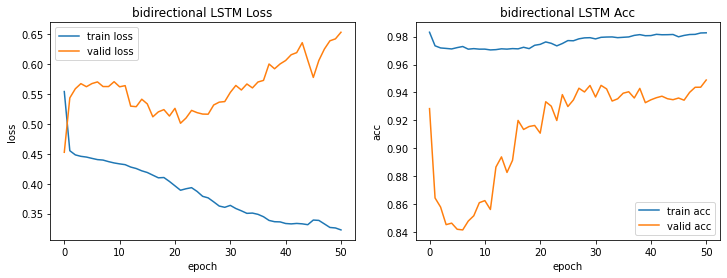

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.set_title("bidirectional LSTM Loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.plot(lstm_train_loss_list, label="train loss")
ax1.plot(lstm_valid_loss_list, label="valid loss")
ax1.legend()
ax2.set_title("bidirectional LSTM Acc")
ax2.set_xlabel("epoch")
ax2.set_ylabel("acc")
ax2.plot(lstm_train_acc_list, label="train acc")
ax2.plot(lstm_valid_acc_list, label="valid acc")
ax2.legend()

#### ROC & PRC

In [ ]:
bi_lstm = bi_LSTM(hidden_size=128, num_layers=1)
bi_lstm.load_state_dict(torch.load(lstm_model_path))
bi_lstm.eval().to(device)
lstm_train_loss, lstm_train_proba = 0, []
lstm_valid_loss, lstm_valid_proba = 0, []
lstm_test_loss, lstm_test_proba = 0, []
with torch.no_grad():
    for x, y in tqdm(train_loader):
        x, y = x.float().to(device), y.float().to(device)
        output = bi_lstm(x)
        loss = criterion(output, y)
        lstm_train_loss += loss.detach().item()
        lstm_train_proba += output.tolist()
    lstm_train_proba = torch.sigmoid(torch.Tensor(lstm_train_proba))
    lstm_train_pred = [1 if prob >= 0.5 else 0 for prob in lstm_train_proba]
    lstm_train_loss = lstm_train_loss/len(train_loader)
    print(f"train loss : {lstm_train_loss}")
    for x, y in tqdm(valid_loader):
        x, y = x.float().to(device), y.float().to(device)
        output = bi_lstm(x)
        loss = criterion(output, y)
        lstm_valid_loss += loss.detach().item()
        lstm_valid_proba += output.tolist()
    lstm_valid_proba = torch.sigmoid(torch.Tensor(lstm_valid_proba))
    lstm_valid_pred = [1 if prob >= 0.5 else 0 for prob in lstm_valid_proba]
    lstm_valid_loss = lstm_valid_loss/len(valid_loader)
    print(f"valid loss : {lstm_valid_loss}")
    for x, y in tqdm(test_loader):
        x, y = x.float().to(device), y.float().to(device)
        output = bi_lstm(x)
        loss = criterion(output, y)
        lstm_test_loss += loss.detach().item()
        lstm_test_proba += output.tolist()
    lstm_test_proba = torch.sigmoid(torch.Tensor(lstm_test_proba))
    lstm_test_pred = [1 if prob >= 0.5 else 0 for prob in lstm_test_proba]
    lstm_test_loss = lstm_test_loss/len(test_loader)
    print(f"test loss : {lstm_test_loss}")

100%|██████████| 103/103 [00:01<00:00, 73.92it/s]


train loss : 0.31349569819505935


100%|██████████| 34/34 [00:00<00:00, 75.72it/s]


valid loss : 0.6529159090098213


100%|██████████| 11/11 [00:00<00:00, 89.29it/s]

test loss : 0.6357180977409537


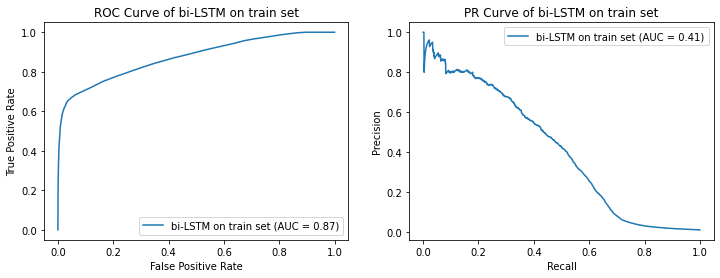

In [ ]:
plot_curve_(train_dataset.y, np.array(lstm_train_proba), "bi-LSTM on train set")

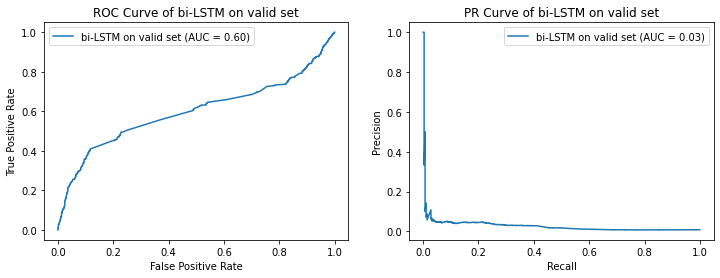

In [ ]:
plot_curve_(valid_dataset.y, np.array(lstm_valid_proba), "bi-LSTM on valid set")

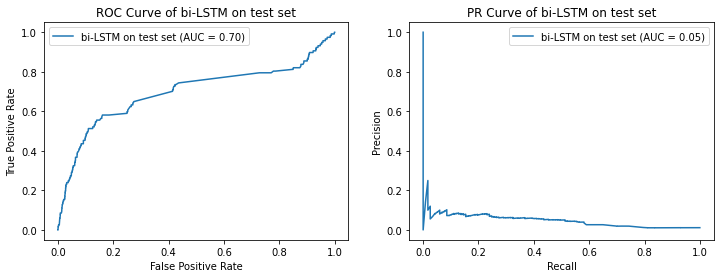

In [ ]:
plot_curve_(test_dataset.y, np.array(lstm_test_proba), "bi-LSTM on test set")

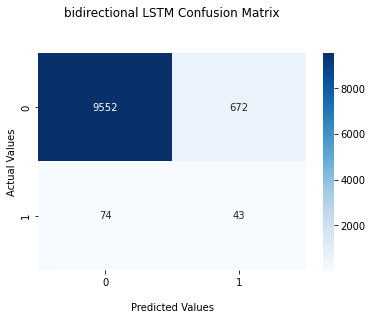

In [ ]:
plot_confusion_matrix(test_dataset.y, lstm_test_pred, "bidirectional LSTM")

### Q5 : Bidirectional-GRU

In [ ]:
gru_model_path = "./models/gru.ckpt"

In [ ]:
class bi_GRU(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(bi_GRU, self).__init__()
        self.gru = nn.GRU(input_size=27, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:,-1,:]).view(-1)
        # out = torch.sigmoid(out)
        return out

In [ ]:
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([20]).to(device))   # use pos_weight to amplify the loss of False Negative
bi_gru = bi_GRU(hidden_size=128, num_layers=1)
# optimizer = torch.optim.SGD(bi_gru.parameters(), lr=lr, momentum=0.9, nesterov=True)
# optimizer = torch.optim.SGD(bi_gru.parameters(), lr=lr, momentum=0)
optimizer = torch.optim.Adam(bi_gru.parameters(), lr=lr, weight_decay=0)
bi_gru.train().to(device)
gru_train_loss_list, gru_valid_loss_list = [], []
gru_train_acc_list, gru_valid_acc_list = [], []
lowest_loss, early_stop_count = float("inf"), 0
for epoch in range(n_epoch):
    train_max_, valid_max_ = 0, 0
    train_correct, valid_correct = 0, 0
    train_loss, valid_loss = 0, 0
    for x, y in train_loader:
        optimizer.zero_grad()
        x, y = x.float().to(device), y.float().to(device)
        output = bi_gru(x)

        train_max_item = max(torch.sigmoid(output))
        # train_max_item = max(output)
        train_max_ = max(train_max_item, train_max_)
        
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        gru_train_pred = [0 if i < 0.5 else 1 for i in output]
        train_loss += loss.detach().item()
        train_correct += sum(torch.Tensor(gru_train_pred)==y.cpu().detach()).item()
    train_loss = train_loss/len(train_loader)
    gru_train_loss_list.append(train_loss)
    train_acc = train_correct/len(train_dataset)
    gru_train_acc_list.append(train_acc)
    
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.float().to(device), y.float().to(device)
            output = bi_gru(x)
            
            valid_max_item = max(torch.sigmoid(output))
            # valid_max_item = max(output)
            valid_max_ = max(valid_max_item, valid_max_)

            loss = criterion(output, y)
            gru_valid_pred = [0 if i < 0.5 else 1 for i in output]
            valid_loss += loss.detach().item()
            valid_correct += sum(torch.Tensor(gru_valid_pred)==y.cpu().detach()).item()
        valid_loss = valid_loss/len(valid_loader)
        gru_valid_loss_list.append(valid_loss)
        valid_acc = valid_correct/len(valid_dataset)
        gru_valid_acc_list.append(valid_acc)

        print("train max item = ", round(train_max_.item(), 4), ", valid max item = ", round(valid_max_.item(), 4))

        torch.save(bi_gru.state_dict(), gru_model_path)

        print(f"epoch {epoch+1} : train loss = {round(train_loss, 4)}, train acc = {train_correct}/{len(train_dataset)} ; valid loss = {round(valid_loss, 4)}, valid acc = {valid_correct}/{len(valid_dataset)}")
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            early_stop_count = 0
            # torch.save(bi_gru.state_dict(), gru_model_path)
            # print(f"Save model at epoch {epoch+1} with valid loss = {round(valid_loss, 4)}")
        else:
            early_stop_count += 1
        
        if early_stop_count >= early_stop:
            print(f'Model is not improving, early stop at epoch {epoch+1}.')
            break

    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{n_epoch}] : Train Loss : {round(train_loss, 4)}, Valid Loss : {round(valid_loss, 4)}')

train max item =  0.8342 , valid max item =  0.8893
epoch 1 : train loss = 0.4923, train acc = 102126/105320 ; valid loss = 0.5553, valid acc = 29198/34362
train max item =  0.838 , valid max item =  0.8788
epoch 2 : train loss = 0.4536, train acc = 102280/105320 ; valid loss = 0.5413, valid acc = 29568/34362
train max item =  0.8436 , valid max item =  0.9205
epoch 3 : train loss = 0.4498, train acc = 102459/105320 ; valid loss = 0.5577, valid acc = 29315/34362
train max item =  0.86 , valid max item =  0.9419
epoch 4 : train loss = 0.4471, train acc = 102454/105320 ; valid loss = 0.5841, valid acc = 28661/34362
train max item =  0.8856 , valid max item =  0.9575
epoch 5 : train loss = 0.4441, train acc = 102475/105320 ; valid loss = 0.6022, valid acc = 28373/34362
train max item =  0.9239 , valid max item =  0.9447
epoch 6 : train loss = 0.4417, train acc = 102432/105320 ; valid loss = 0.5801, valid acc = 28697/34362
train max item =  0.9352 , valid max item =  0.9704
epoch 7 : train

#### Loss Curve

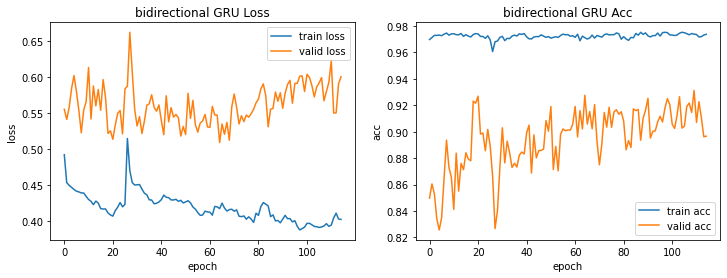

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.set_title("bidirectional GRU Loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.plot(gru_train_loss_list, label="train loss")
ax1.plot(gru_valid_loss_list, label="valid loss")
ax1.legend()
ax2.set_title("bidirectional GRU Acc")
ax2.set_xlabel("epoch")
ax2.set_ylabel("acc")
ax2.plot(gru_train_acc_list, label="train acc")
ax2.plot(gru_valid_acc_list, label="valid acc")
ax2.legend()

#### ROC & PRC

In [ ]:
bi_gru = bi_GRU(hidden_size=128, num_layers=1)
bi_gru.load_state_dict(torch.load(gru_model_path))
bi_gru.eval().to(device)
gru_train_loss, gru_train_proba = 0, []
gru_valid_loss, gru_valid_proba = 0, []
gru_test_loss, gru_test_proba = 0, []
with torch.no_grad():
    for x, y in tqdm(train_loader):
        x, y = x.float().to(device), y.float().to(device)
        output = bi_gru(x)
        loss = criterion(output, y)
        gru_train_loss += loss.detach().item()
        gru_train_proba += output.tolist()
    gru_train_proba = torch.sigmoid(torch.Tensor(gru_train_proba))
    gru_train_pred = [1 if prob >= 0.5 else 0 for prob in gru_train_proba]
    gru_train_loss = gru_train_loss/len(train_loader)
    print(f"train loss : {gru_train_loss}")
    for x, y in tqdm(valid_loader):
        x, y = x.float().to(device), y.float().to(device)
        output = bi_gru(x)
        loss = criterion(output, y)
        gru_valid_loss += loss.detach().item()
        gru_valid_proba += output.tolist()
    gru_valid_proba = torch.sigmoid(torch.Tensor(gru_valid_proba))
    gru_valid_pred = [1 if prob >= 0.5 else 0 for prob in gru_valid_proba]
    gru_valid_loss = gru_valid_loss/len(valid_loader)
    print(f"valid loss : {gru_valid_loss}")
    for x, y in tqdm(test_loader):
        x, y = x.float().to(device), y.float().to(device)
        output = bi_gru(x)
        loss = criterion(output, y)
        gru_test_loss += loss.detach().item()
        gru_test_proba += output.tolist()
    gru_test_proba = torch.sigmoid(torch.Tensor(gru_test_proba))
    gru_test_pred = [1 if prob >= 0.5 else 0 for prob in gru_test_proba]
    gru_test_loss = gru_test_loss/len(test_loader)
    print(f"test loss : {gru_test_loss}")

100%|██████████| 103/103 [00:01<00:00, 84.41it/s]


train loss : 0.40115904931015184


100%|██████████| 34/34 [00:00<00:00, 102.41it/s]


valid loss : 0.6004267212222604


100%|██████████| 11/11 [00:00<00:00, 110.19it/s]

test loss : 0.6048533130775798


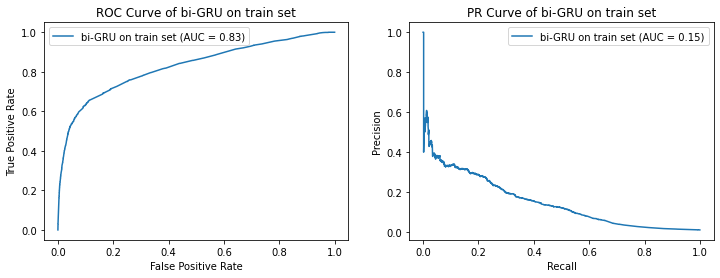

In [ ]:
plot_curve_(train_dataset.y, np.array(gru_train_proba), "bi-GRU on train set")

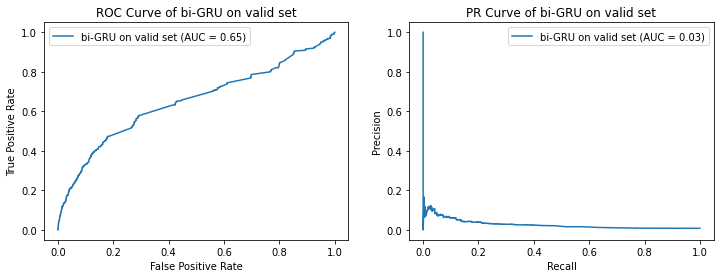

In [ ]:
plot_curve_(valid_dataset.y, np.array(gru_valid_proba), "bi-GRU on valid set")

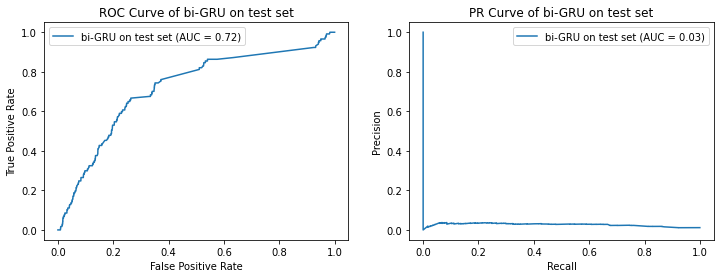

In [ ]:
plot_curve_(test_dataset.y, np.array(gru_test_proba), "bi-GRU on test set")

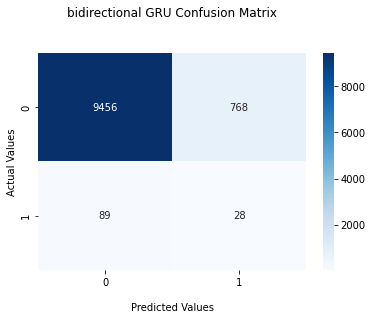

In [ ]:
plot_confusion_matrix(test_dataset.y, gru_test_pred, "bidirectional GRU")

### Q6 : Transformer

In [ ]:
transformer_model_path = "./models/transformer.ckpt"

In [ ]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.transformer_encoder = nn.TransformerEncoderLayer(d_model=27, nhead=3, batch_first=True)
        self.fc = nn.Linear(11*27, 1)
    def forward(self, x):
        out = self.transformer_encoder(x)
        out = out.view(-1, 11*27)
        out = self.fc(out).view(-1)
        # out = torch.sigmoid(out)
        return out

In [ ]:
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([20]).to(device))   # use pos_weight to amplify the loss of False Negative
transformer = Transformer()
# optimizer = torch.optim.SGD(transformer.parameters(), lr=lr, momentum=0.9, nesterov=True)
# optimizer = torch.optim.SGD(transformer.parameters(), lr=lr, momentum=0)
optimizer = torch.optim.Adam(transformer.parameters(), lr=lr, weight_decay=0)
transformer.train().to(device)
transformer_train_loss_list, transformer_valid_loss_list = [], []
transformer_train_acc_list, transformer_valid_acc_list = [], []
lowest_loss, early_stop_count = float("inf"), 0
for epoch in range(n_epoch):
    train_max_, valid_max_ = 0, 0
    train_correct, valid_correct = 0, 0
    train_loss, valid_loss = 0, 0
    for x, y in train_loader:
        optimizer.zero_grad()
        x, y = x.float().to(device), y.float().to(device)
        output = transformer(x)

        train_max_item = max(torch.sigmoid(output))
        # train_max_item = max(output)
        train_max_ = max(train_max_item, train_max_)
        
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        transformer_train_pred = [0 if i < 0.5 else 1 for i in output]
        train_loss += loss.detach().item()
        train_correct += sum(torch.Tensor(transformer_train_pred)==y.cpu().detach()).item()
    train_loss = train_loss/len(train_loader)
    transformer_train_loss_list.append(train_loss)
    train_acc = train_correct/len(train_dataset)
    transformer_train_acc_list.append(train_acc)
    
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.float().to(device), y.float().to(device)
            output = transformer(x)
            
            valid_max_item = max(torch.sigmoid(output))
            # valid_max_item = max(output)
            valid_max_ = max(valid_max_item, valid_max_)

            loss = criterion(output, y)
            transformer_valid_pred = [0 if i < 0.5 else 1 for i in output]
            valid_loss += loss.detach().item()
            valid_correct += sum(torch.Tensor(transformer_valid_pred)==y.cpu().detach()).item()
        valid_loss = valid_loss/len(valid_loader)
        transformer_valid_loss_list.append(valid_loss)
        valid_acc = valid_correct/len(valid_dataset)
        transformer_valid_acc_list.append(valid_acc)

        print("train max item = ", round(train_max_.item(), 4), ", valid max item = ", round(valid_max_.item(), 4))

        torch.save(transformer.state_dict(), transformer_model_path)

        print(f"epoch {epoch+1} : train loss = {round(train_loss, 4)}, train acc = {train_correct}/{len(train_dataset)} ; valid loss = {round(valid_loss, 4)}, valid acc = {valid_correct}/{len(valid_dataset)}")
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            early_stop_count = 0
            # torch.save(transformer.state_dict(), transformer_model_path)
            # print(f"Save model at epoch {epoch+1} with valid loss = {round(valid_loss, 4)}")
        else:
            early_stop_count += 1
        
        if early_stop_count >= early_stop:
            print(f'Model is not improving, early stop at epoch {epoch+1}.')
            break

    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{n_epoch}] : Train Loss : {round(train_loss, 4)}, Valid Loss : {round(valid_loss, 4)}')

train max item =  0.9348 , valid max item =  0.8966
epoch 1 : train loss = 0.5271, train acc = 101703/105320 ; valid loss = 0.45, valid acc = 31166/34362
train max item =  0.9162 , valid max item =  0.9177
epoch 2 : train loss = 0.4681, train acc = 102074/105320 ; valid loss = 0.4834, valid acc = 31078/34362
train max item =  0.9246 , valid max item =  0.9137
epoch 3 : train loss = 0.4587, train acc = 102337/105320 ; valid loss = 0.5538, valid acc = 30072/34362
train max item =  0.9016 , valid max item =  0.9237
epoch 4 : train loss = 0.4567, train acc = 102356/105320 ; valid loss = 0.5619, valid acc = 29716/34362
train max item =  0.9271 , valid max item =  0.9569
epoch 5 : train loss = 0.4515, train acc = 102155/105320 ; valid loss = 0.5903, valid acc = 29096/34362
train max item =  0.9309 , valid max item =  0.9545
epoch 6 : train loss = 0.4485, train acc = 102307/105320 ; valid loss = 0.5792, valid acc = 29157/34362
train max item =  0.9548 , valid max item =  0.9641
epoch 7 : trai

#### Loss Curve

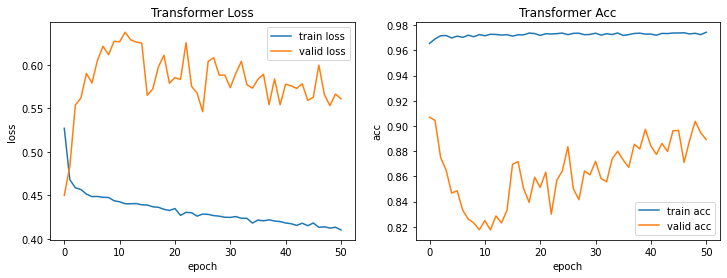

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.set_title("Transformer Loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.plot(transformer_train_loss_list, label="train loss")
ax1.plot(transformer_valid_loss_list, label="valid loss")
ax1.legend()
ax2.set_title("Transformer Acc")
ax2.set_xlabel("epoch")
ax2.set_ylabel("acc")
ax2.plot(transformer_train_acc_list, label="train acc")
ax2.plot(transformer_valid_acc_list, label="valid acc")
ax2.legend()

#### ROC & PRC

In [ ]:
transformer = Transformer()
transformer.load_state_dict(torch.load(transformer_model_path))
transformer.eval().to(device)
transformer_train_loss, transformer_train_proba = 0, []
transformer_valid_loss, transformer_valid_proba = 0, []
transformer_test_loss, transformer_test_proba = 0, []
with torch.no_grad():
    for x, y in tqdm(train_loader):
        x, y = x.float().to(device), y.float().to(device)
        output = transformer(x)
        loss = criterion(output, y)
        transformer_train_loss += loss.detach().item()
        transformer_train_proba += output.tolist()
    transformer_train_proba = torch.sigmoid(torch.Tensor(transformer_train_proba))
    transformer_train_pred = [1 if prob >= 0.5 else 0 for prob in transformer_train_proba]
    transformer_train_loss = transformer_train_loss/len(train_loader)
    print(f"train loss : {transformer_train_loss}")
    for x, y in tqdm(valid_loader):
        x, y = x.float().to(device), y.float().to(device)
        output = transformer(x)
        loss = criterion(output, y)
        transformer_valid_loss += loss.detach().item()
        transformer_valid_proba += output.tolist()
    transformer_valid_proba = torch.sigmoid(torch.Tensor(transformer_valid_proba))
    transformer_valid_pred = [1 if prob >= 0.5 else 0 for prob in transformer_valid_proba]
    transformer_valid_loss = transformer_valid_loss/len(valid_loader)
    print(f"valid loss : {transformer_valid_loss}")
    for x, y in tqdm(test_loader):
        x, y = x.float().to(device), y.float().to(device)
        output = transformer(x)
        loss = criterion(output, y)
        transformer_test_loss += loss.detach().item()
        transformer_test_proba += output.tolist()
    transformer_test_proba = torch.sigmoid(torch.Tensor(transformer_test_proba))
    transformer_test_pred = [1 if prob >= 0.5 else 0 for prob in transformer_test_proba]
    transformer_test_loss = transformer_test_loss/len(test_loader)
    print(f"test loss : {transformer_test_loss}")

100%|██████████| 103/103 [00:01<00:00, 57.00it/s]


train loss : 0.3926610435241634


100%|██████████| 34/34 [00:00<00:00, 90.63it/s]


valid loss : 0.5634117091403288


100%|██████████| 11/11 [00:00<00:00, 103.73it/s]

test loss : 0.6046290858225389


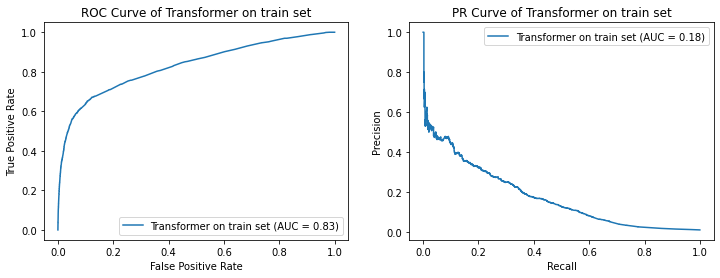

In [ ]:
plot_curve_(train_dataset.y, np.array(transformer_train_proba), "Transformer on train set")

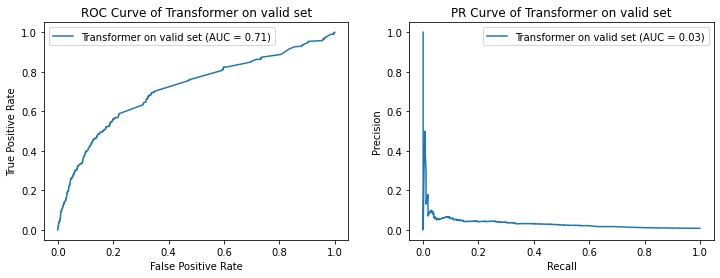

In [ ]:
plot_curve_(valid_dataset.y, np.array(transformer_valid_proba), "Transformer on valid set")

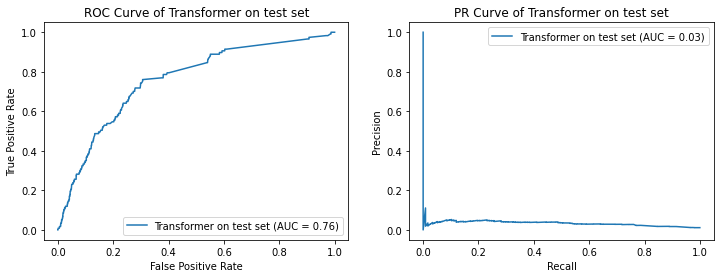

In [ ]:
plot_curve_(test_dataset.y, np.array(transformer_test_proba), "Transformer on test set")

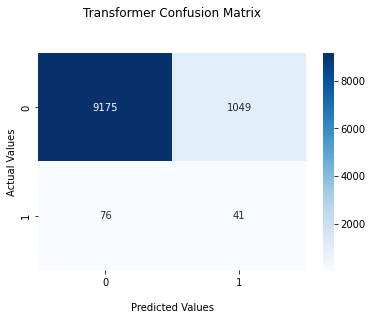

In [ ]:
plot_confusion_matrix(test_dataset.y, transformer_test_pred, "Transformer")

### Q8 : Ablation Study on sequence length

#### Model with last 3

In [ ]:
class CTRPredictDataset_last3(Dataset):
    def __init__(self, data_df):
        self.x = torch.Tensor([np.array(history[-3:] + [target]) for (history, target) in zip(data_df['click_seq_10_onehot'].values, data_df['target_news_onehot'].values)])
        self.y = torch.Tensor(data_df['y'].values)
        self.pos_num = sum(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    def __len__(self):
        return len(self.x)

In [ ]:
train_dataset_last3 = CTRPredictDataset_last3(train_df)
valid_dataset_last3 = CTRPredictDataset_last3(valid_df)
test_dataset_last3 = CTRPredictDataset_last3(test_df)

train_loader_last3 = DataLoader(train_dataset_last3, batch_size=batch_size, shuffle=False, pin_memory=True)
valid_loader_last3 = DataLoader(valid_dataset_last3, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader_last3 = DataLoader(test_dataset_last3, batch_size=batch_size, shuffle=False, pin_memory=True)

In [15]:
class bi_LSTM(nn.Module):
    def __init__(self, hidden_size=128, num_layers=1):
        super(bi_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=27, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:,-1,:]).view(-1)
        # out = torch.sigmoid(out) 
        return out

##### Training

In [18]:
lstm_last3_model_path = "./models/lstm_last3.ckpt"

In [16]:
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([20]).to(device))   # use pos_weight to amplify the loss of False Negative
bi_lstm_last3 = bi_LSTM(hidden_size=128, num_layers=1)
# optimizer = torch.optim.SGD(bi_lstm_last3.parameters(), lr=lr, momentum=0.9, nesterov=True)
# optimizer = torch.optim.SGD(bi_lstm_last3.parameters(), lr=lr, momentum=0)
optimizer = torch.optim.Adam(bi_lstm_last3.parameters(), lr=lr, weight_decay=0)
bi_lstm_last3.train().to(device)
lstm_last3_train_loss_list, lstm_last3_valid_loss_list = [], []
lstm_last3_train_acc_list, lstm_last3_valid_acc_list = [], []
lowest_loss, early_stop_count = float("inf"), 0
for epoch in range(n_epoch):
    train_max_, valid_max_ = 0, 0
    train_correct, valid_correct = 0, 0
    train_loss, valid_loss = 0, 0
    for x, y in train_loader_last3:
        optimizer.zero_grad()
        x, y = x.float().to(device), y.float().to(device)
        output = bi_lstm_last3(x)

        train_max_item = max(torch.sigmoid(output))
        # train_max_item = max(output)
        train_max_ = max(train_max_item, train_max_)
        
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        lstm_last3_train_pred = [0 if i < 0.5 else 1 for i in output]
        train_loss += loss.detach().item()
        train_correct += sum(torch.Tensor(lstm_last3_train_pred)==y.cpu().detach()).item()
    train_loss = train_loss/len(train_loader)
    lstm_last3_train_loss_list.append(train_loss)
    train_acc = train_correct/len(train_dataset)
    lstm_last3_train_acc_list.append(train_acc)
    
    with torch.no_grad():
        for x, y in valid_loader_last3:
            x, y = x.float().to(device), y.float().to(device)
            output = bi_lstm_last3(x)
            
            valid_max_item = max(torch.sigmoid(output))
            # valid_max_item = max(output)
            valid_max_ = max(valid_max_item, valid_max_)

            loss = criterion(output, y)
            lstm_last3_valid_pred = [0 if i < 0.5 else 1 for i in output]
            valid_loss += loss.detach().item()
            valid_correct += sum(torch.Tensor(lstm_last3_valid_pred)==y.cpu().detach()).item()
        valid_loss = valid_loss/len(valid_loader)
        lstm_last3_valid_loss_list.append(valid_loss)
        valid_acc = valid_correct/len(valid_dataset)
        lstm_last3_valid_acc_list.append(valid_acc)

        print("train max item = ", round(train_max_.item(), 4), ", valid max item = ", round(valid_max_.item(), 4))

        torch.save(bi_lstm_last3.state_dict(), lstm_last3_model_path)

        print(f"epoch {epoch+1} : train loss = {round(train_loss, 4)}, train acc = {train_correct}/{len(train_dataset)} ; valid loss = {round(valid_loss, 4)}, valid acc = {valid_correct}/{len(valid_dataset)}")
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            early_stop_count = 0
            # torch.save(bi_lstm_last3.state_dict(), lstm_last3_model_path)
            # print(f"Save model at epoch {epoch+1} with valid loss = {round(valid_loss, 4)}")
        else:
            early_stop_count += 1
        
        if early_stop_count >= early_stop:
            print(f'Model is not improving, early stop at epoch {epoch+1}.')
            break

    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{n_epoch}] : Train Loss : {round(train_loss, 4)}, Valid Loss : {round(valid_loss, 4)}')

train max item =  0.8013 , valid max item =  0.799
epoch 1 : train loss = 0.4984, train acc = 102331/105320 ; valid loss = 0.5277, valid acc = 29091/34362
train max item =  0.8016 , valid max item =  0.7735
epoch 2 : train loss = 0.4617, train acc = 102871/105320 ; valid loss = 0.5105, valid acc = 29962/34362
train max item =  0.7991 , valid max item =  0.7629
epoch 3 : train loss = 0.4574, train acc = 102968/105320 ; valid loss = 0.5279, valid acc = 29980/34362
train max item =  0.8001 , valid max item =  0.7889
epoch 4 : train loss = 0.4562, train acc = 102973/105320 ; valid loss = 0.5233, valid acc = 30109/34362
train max item =  0.8015 , valid max item =  0.8417
epoch 5 : train loss = 0.4526, train acc = 102836/105320 ; valid loss = 0.523, valid acc = 30062/34362
train max item =  0.8536 , valid max item =  0.8847
epoch 6 : train loss = 0.4497, train acc = 102766/105320 ; valid loss = 0.5377, valid acc = 29791/34362
train max item =  0.8844 , valid max item =  0.9082
epoch 7 : trai

##### Loss Curve

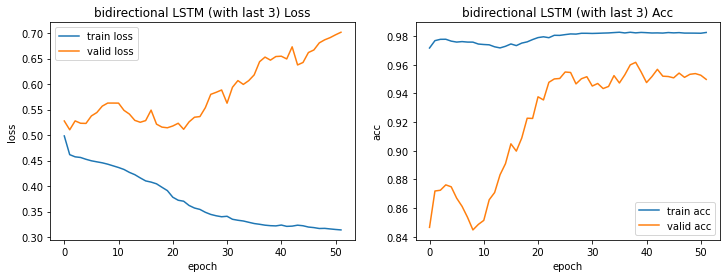

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.set_title("bidirectional LSTM (with last 3) Loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.plot(lstm_last3_train_loss_list, label="train loss")
ax1.plot(lstm_last3_valid_loss_list, label="valid loss")
ax1.legend()
ax2.set_title("bidirectional LSTM (with last 3) Acc")
ax2.set_xlabel("epoch")
ax2.set_ylabel("acc")
ax2.plot(lstm_last3_train_acc_list, label="train acc")
ax2.plot(lstm_last3_valid_acc_list, label="valid acc")
ax2.legend()

##### ROC & PRC

In [22]:
bi_lstm_last3 = bi_LSTM(hidden_size=128, num_layers=1)
bi_lstm_last3.load_state_dict(torch.load(lstm_last3_model_path))
bi_lstm_last3.eval().to(device)
lstm_last3_train_loss, lstm_last3_train_proba = 0, []
lstm_last3_valid_loss, lstm_last3_valid_proba = 0, []
lstm_last3_test_loss, lstm_last3_test_proba = 0, []
with torch.no_grad():
    for x, y in tqdm(train_loader_last3):
        x, y = x.float().to(device), y.float().to(device)
        output = bi_lstm_last3(x)
        loss = criterion(output, y)
        lstm_last3_train_loss += loss.detach().item()
        lstm_last3_train_proba += output.tolist()
    lstm_last3_train_proba = torch.sigmoid(torch.Tensor(lstm_last3_train_proba))
    lstm_last3_train_pred = [1 if prob >= 0.5 else 0 for prob in lstm_last3_train_proba]
    lstm_last3_train_loss = lstm_last3_train_loss/len(train_loader_last3)
    print(f"train loss : {lstm_last3_train_loss}")
    for x, y in tqdm(valid_loader_last3):
        x, y = x.float().to(device), y.float().to(device)
        output = bi_lstm_last3(x)
        loss = criterion(output, y)
        lstm_last3_valid_loss += loss.detach().item()
        lstm_last3_valid_proba += output.tolist()
    lstm_last3_valid_proba = torch.sigmoid(torch.Tensor(lstm_last3_valid_proba))
    lstm_last3_valid_pred = [1 if prob >= 0.5 else 0 for prob in lstm_last3_valid_proba]
    lstm_last3_valid_loss = lstm_last3_valid_loss/len(valid_loader_last3)
    print(f"valid loss : {lstm_last3_valid_loss}")
    for x, y in tqdm(test_loader_last3):
        x, y = x.float().to(device), y.float().to(device)
        output = bi_lstm_last3(x)
        loss = criterion(output, y)
        lstm_last3_test_loss += loss.detach().item()
        lstm_last3_test_proba += output.tolist()
    lstm_last3_test_proba = torch.sigmoid(torch.Tensor(lstm_last3_test_proba))
    lstm_last3_test_pred = [1 if prob >= 0.5 else 0 for prob in lstm_last3_test_proba]
    lstm_last3_test_loss = lstm_last3_test_loss/len(test_loader_last3)
    print(f"test loss : {lstm_last3_test_loss}")

100%|██████████| 103/103 [00:00<00:00, 137.79it/s]


train loss : 0.3063975247075257


100%|██████████| 34/34 [00:00<00:00, 143.83it/s]


valid loss : 0.7016337154542699


100%|██████████| 11/11 [00:00<00:00, 146.32it/s]

test loss : 0.7143604945052754


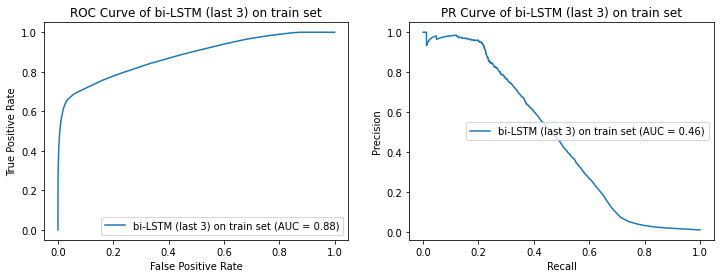

In [23]:
plot_curve_(train_dataset.y, np.array(lstm_last3_train_proba), "bi-LSTM (last 3) on train set")

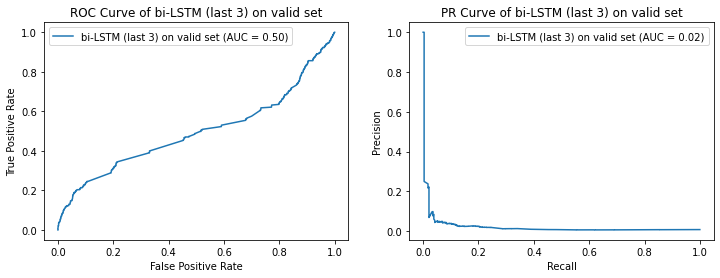

In [25]:
plot_curve_(valid_dataset.y, np.array(lstm_last3_valid_proba), "bi-LSTM (last 3) on valid set")

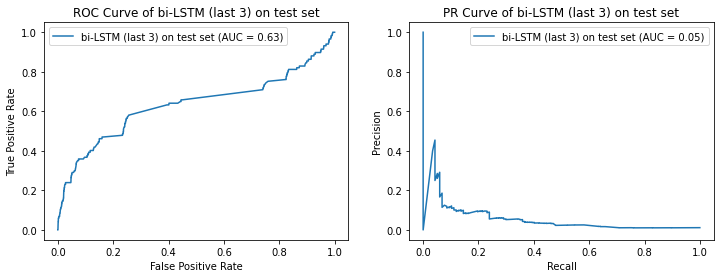

In [26]:
plot_curve_(test_dataset.y, np.array(lstm_last3_test_proba), "bi-LSTM (last 3) on test set")

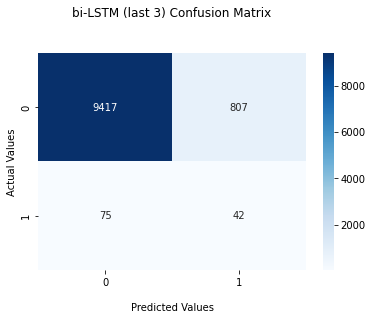

In [34]:
plot_confusion_matrix(test_dataset.y, lstm_last3_test_pred, "bi-LSTM (last 3)")

#### Model with last 5

In [36]:
class CTRPredictDataset_last5(Dataset):
    def __init__(self, data_df):
        self.x = torch.Tensor([np.array(history[-5:] + [target]) for (history, target) in zip(data_df['click_seq_10_onehot'].values, data_df['target_news_onehot'].values)])
        self.y = torch.Tensor(data_df['y'].values)
        self.pos_num = sum(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    def __len__(self):
        return len(self.x)

In [37]:
train_dataset_last5 = CTRPredictDataset_last5(train_df)
valid_dataset_last5 = CTRPredictDataset_last5(valid_df)
test_dataset_last5 = CTRPredictDataset_last5(test_df)

train_loader_last5 = DataLoader(train_dataset_last5, batch_size=batch_size, shuffle=False, pin_memory=True)
valid_loader_last5 = DataLoader(valid_dataset_last5, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader_last5 = DataLoader(test_dataset_last5, batch_size=batch_size, shuffle=False, pin_memory=True)

In [38]:
class bi_LSTM(nn.Module):
    def __init__(self, hidden_size=128, num_layers=1):
        super(bi_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=27, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:,-1,:]).view(-1)
        # out = torch.sigmoid(out) 
        return out

##### Training

In [39]:
lstm_last5_model_path = "./models/lstm_last5.ckpt"

In [40]:
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([20]).to(device))   # use pos_weight to amplify the loss of False Negative
bi_lstm_last5 = bi_LSTM(hidden_size=128, num_layers=1)
# optimizer = torch.optim.SGD(bi_lstm_last5.parameters(), lr=lr, momentum=0.9, nesterov=True)
# optimizer = torch.optim.SGD(bi_lstm_last5.parameters(), lr=lr, momentum=0)
optimizer = torch.optim.Adam(bi_lstm_last5.parameters(), lr=lr, weight_decay=0)
bi_lstm_last5.train().to(device)
lstm_last5_train_loss_list, lstm_last5_valid_loss_list = [], []
lstm_last5_train_acc_list, lstm_last5_valid_acc_list = [], []
lowest_loss, early_stop_count = float("inf"), 0
for epoch in range(n_epoch):
    train_max_, valid_max_ = 0, 0
    train_correct, valid_correct = 0, 0
    train_loss, valid_loss = 0, 0
    for x, y in train_loader_last5:
        optimizer.zero_grad()
        x, y = x.float().to(device), y.float().to(device)
        output = bi_lstm_last5(x)

        train_max_item = max(torch.sigmoid(output))
        # train_max_item = max(output)
        train_max_ = max(train_max_item, train_max_)
        
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        lstm_last5_train_pred = [0 if i < 0.5 else 1 for i in output]
        train_loss += loss.detach().item()
        train_correct += sum(torch.Tensor(lstm_last5_train_pred)==y.cpu().detach()).item()
    train_loss = train_loss/len(train_loader)
    lstm_last5_train_loss_list.append(train_loss)
    train_acc = train_correct/len(train_dataset)
    lstm_last5_train_acc_list.append(train_acc)
    
    with torch.no_grad():
        for x, y in valid_loader_last5:
            x, y = x.float().to(device), y.float().to(device)
            output = bi_lstm_last5(x)
            
            valid_max_item = max(torch.sigmoid(output))
            # valid_max_item = max(output)
            valid_max_ = max(valid_max_item, valid_max_)

            loss = criterion(output, y)
            lstm_last5_valid_pred = [0 if i < 0.5 else 1 for i in output]
            valid_loss += loss.detach().item()
            valid_correct += sum(torch.Tensor(lstm_last5_valid_pred)==y.cpu().detach()).item()
        valid_loss = valid_loss/len(valid_loader)
        lstm_last5_valid_loss_list.append(valid_loss)
        valid_acc = valid_correct/len(valid_dataset)
        lstm_last5_valid_acc_list.append(valid_acc)

        print("train max item = ", round(train_max_.item(), 4), ", valid max item = ", round(valid_max_.item(), 4))

        torch.save(bi_lstm_last5.state_dict(), lstm_last5_model_path)

        print(f"epoch {epoch+1} : train loss = {round(train_loss, 4)}, train acc = {train_correct}/{len(train_dataset)} ; valid loss = {round(valid_loss, 4)}, valid acc = {valid_correct}/{len(valid_dataset)}")
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            early_stop_count = 0
            # torch.save(bi_lstm_last5.state_dict(), lstm_last5_model_path)
            # print(f"Save model at epoch {epoch+1} with valid loss = {round(valid_loss, 4)}")
        else:
            early_stop_count += 1
        
        if early_stop_count >= early_stop:
            print(f'Model is not improving, early stop at epoch {epoch+1}.')
            break

    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{n_epoch}] : Train Loss : {round(train_loss, 4)}, Valid Loss : {round(valid_loss, 4)}')
    

train max item =  0.8676 , valid max item =  0.7472
epoch 1 : train loss = 0.5504, train acc = 103296/105320 ; valid loss = 0.5308, valid acc = 29009/34362
train max item =  0.7519 , valid max item =  0.7815
epoch 2 : train loss = 0.4618, train acc = 102322/105320 ; valid loss = 0.5124, valid acc = 29861/34362
train max item =  0.8138 , valid max item =  0.8924
epoch 3 : train loss = 0.4533, train acc = 102441/105320 ; valid loss = 0.5356, valid acc = 29801/34362
train max item =  0.8629 , valid max item =  0.882
epoch 4 : train loss = 0.4498, train acc = 102606/105320 ; valid loss = 0.536, valid acc = 29588/34362
train max item =  0.8762 , valid max item =  0.9269
epoch 5 : train loss = 0.4471, train acc = 102584/105320 ; valid loss = 0.5389, valid acc = 29987/34362
train max item =  0.9247 , valid max item =  0.9
epoch 6 : train loss = 0.4447, train acc = 102455/105320 ; valid loss = 0.5415, valid acc = 29928/34362
train max item =  0.9006 , valid max item =  0.9252
epoch 7 : train l

##### Loss Curve

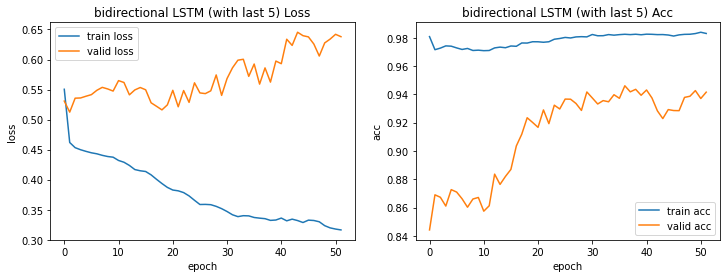

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.set_title("bidirectional LSTM (with last 5) Loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.plot(lstm_last5_train_loss_list, label="train loss")
ax1.plot(lstm_last5_valid_loss_list, label="valid loss")
ax1.legend()
ax2.set_title("bidirectional LSTM (with last 5) Acc")
ax2.set_xlabel("epoch")
ax2.set_ylabel("acc")
ax2.plot(lstm_last5_train_acc_list, label="train acc")
ax2.plot(lstm_last5_valid_acc_list, label="valid acc")
ax2.legend()

##### ROC & PRC

In [42]:
bi_lstm_last5 = bi_LSTM(hidden_size=128, num_layers=1)
bi_lstm_last5.load_state_dict(torch.load(lstm_last5_model_path))
bi_lstm_last5.eval().to(device)
lstm_last5_train_loss, lstm_last5_train_proba = 0, []
lstm_last5_valid_loss, lstm_last5_valid_proba = 0, []
lstm_last5_test_loss, lstm_last5_test_proba = 0, []
with torch.no_grad():
    for x, y in tqdm(train_loader_last5):
        x, y = x.float().to(device), y.float().to(device)
        output = bi_lstm_last5(x)
        loss = criterion(output, y)
        lstm_last5_train_loss += loss.detach().item()
        lstm_last5_train_proba += output.tolist()
    lstm_last5_train_proba = torch.sigmoid(torch.Tensor(lstm_last5_train_proba))
    lstm_last5_train_pred = [1 if prob >= 0.5 else 0 for prob in lstm_last5_train_proba]
    lstm_last5_train_loss = lstm_last5_train_loss/len(train_loader_last5)
    print(f"train loss : {lstm_last5_train_loss}")
    for x, y in tqdm(valid_loader_last5):
        x, y = x.float().to(device), y.float().to(device)
        output = bi_lstm_last5(x)
        loss = criterion(output, y)
        lstm_last5_valid_loss += loss.detach().item()
        lstm_last5_valid_proba += output.tolist()
    lstm_last5_valid_proba = torch.sigmoid(torch.Tensor(lstm_last5_valid_proba))
    lstm_last5_valid_pred = [1 if prob >= 0.5 else 0 for prob in lstm_last5_valid_proba]
    lstm_last5_valid_loss = lstm_last5_valid_loss/len(valid_loader_last5)
    print(f"valid loss : {lstm_last5_valid_loss}")
    for x, y in tqdm(test_loader_last5):
        x, y = x.float().to(device), y.float().to(device)
        output = bi_lstm_last5(x)
        loss = criterion(output, y)
        lstm_last5_test_loss += loss.detach().item()
        lstm_last5_test_proba += output.tolist()
    lstm_last5_test_proba = torch.sigmoid(torch.Tensor(lstm_last5_test_proba))
    lstm_last5_test_pred = [1 if prob >= 0.5 else 0 for prob in lstm_last5_test_proba]
    lstm_last5_test_loss = lstm_last5_test_loss/len(test_loader_last5)
    print(f"test loss : {lstm_last5_test_loss}")

100%|██████████| 103/103 [00:00<00:00, 124.32it/s]


train loss : 0.3091292660502554


100%|██████████| 34/34 [00:00<00:00, 136.54it/s]


valid loss : 0.6380004751331666


100%|██████████| 11/11 [00:00<00:00, 146.04it/s]

test loss : 0.7654121924530376


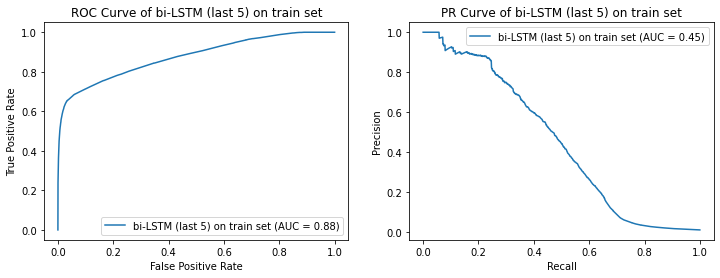

In [43]:
plot_curve_(train_dataset.y, np.array(lstm_last5_train_proba), "bi-LSTM (last 5) on train set")

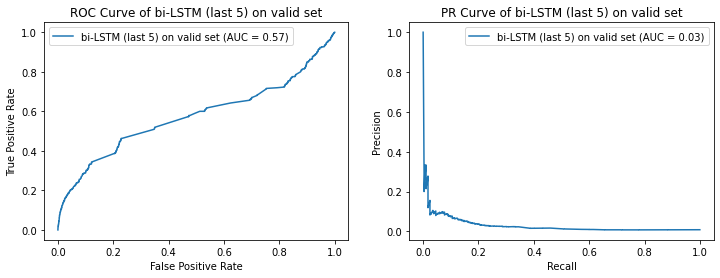

In [44]:
plot_curve_(valid_dataset.y, np.array(lstm_last5_valid_proba), "bi-LSTM (last 5) on valid set")

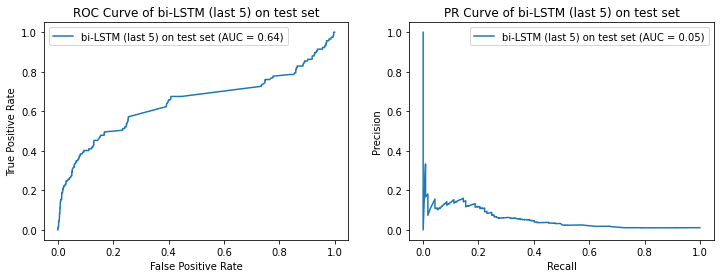

In [45]:
plot_curve_(test_dataset.y, np.array(lstm_last5_test_proba), "bi-LSTM (last 5) on test set")

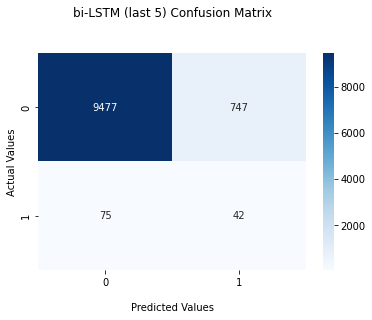

In [46]:
plot_confusion_matrix(test_dataset.y, lstm_last5_test_pred, "bi-LSTM (last 5)")